# Import necessary libraries

In [79]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [80]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Data Exploration and EDA

## 1.1 Import the dataset

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive/Vradnyk_Assignment_2


In [83]:
folder_name = "Vradnyk_Assignment_2"
folder_path = os.path.join("/content/drive/MyDrive/", folder_name)

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_name}' created successfully.")
    %cd {folder_path}
else:
    print(f"Folder '{folder_name}' already exists.")
    %cd {folder_path}

print(f"Current working directory: {os.getcwd()}")


Folder 'Vradnyk_Assignment_2' already exists.
/content/drive/MyDrive/Vradnyk_Assignment_2
Current working directory: /content/drive/MyDrive/Vradnyk_Assignment_2


In [84]:
uploaded = files.upload()

Saving wines_SPA.csv to wines_SPA (1).csv


In [85]:
wine_data = pd.read_csv('wines_SPA.csv')

### Display the first few rows

In [86]:
print("First few rows of the dataset:")
wine_data.head()

First few rows of the dataset:


,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [87]:
print("\nData Types:\n", wine_data.dtypes)


Data Types:
 winery          object
wine            object
year            object
rating         float64
num_reviews      int64
country         object
region          object
price          float64
type            object
body           float64
acidity        float64
dtype: object


## 1.2 Summary statistics for numerical columns

In [88]:
print("\nSummary statistics for numerical columns:")
wine_data.describe()


Summary statistics for numerical columns:


,rating,num_reviews,price,body,acidity
count,7500.000000,7500.000000,7500.000000,6331.000000,6331.000000
mean,4.254933,451.109067,60.095822,4.158427,2.946612
std,0.118029,723.001856,150.356676,0.583352,0.248202
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.200000,389.000000,18.900000,4.000000,3.000000
50%,4.200000,404.000000,28.530000,4.000000,3.000000
75%,4.200000,415.000000,51.350000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


## 1.3 Visualize the distribution of each numerical feature

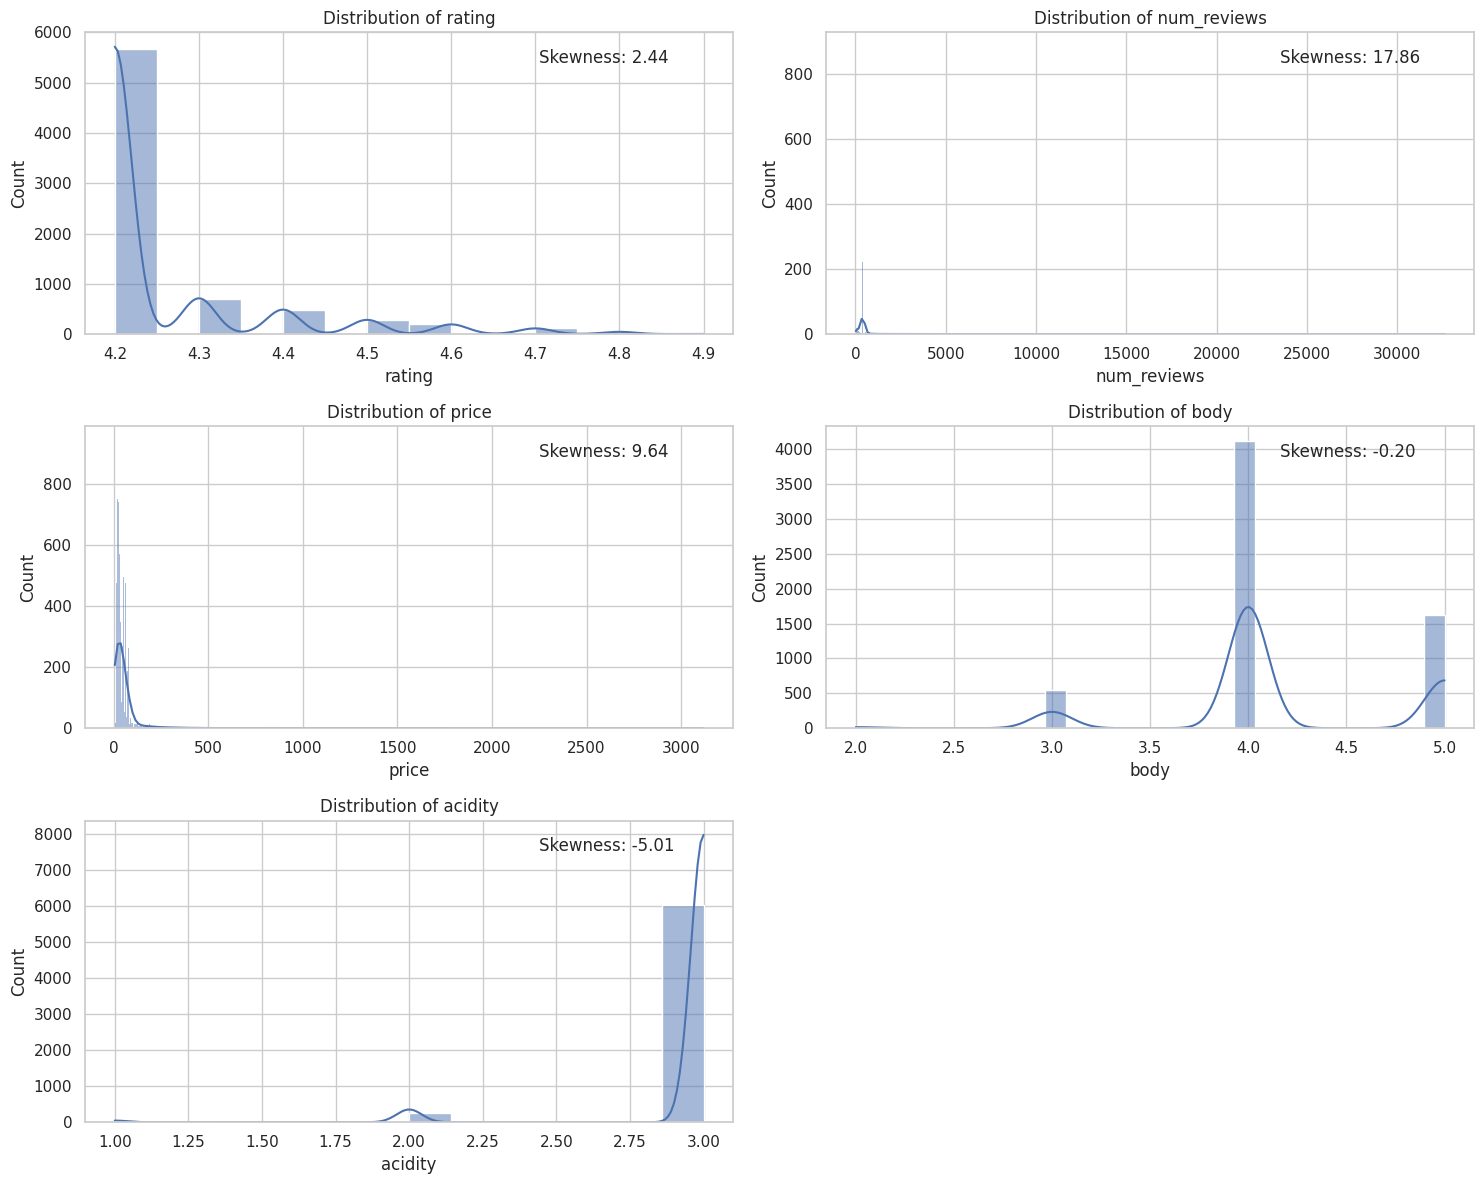

In [89]:
def plot_distributions(df):
    """
    Plot histograms and density plots for all numerical features
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Grid size
    n_cols = 2
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        # Plot histogram with density overlay
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

        # Calculate skewness
        skewness = df[col].skew()
        axes[i].annotate(f'Skewness: {skewness:.2f}',
                         xy=(0.7, 0.9),
                         xycoords='axes fraction')

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_distributions(wine_data)

## 1.4 Analyze correlation matrix

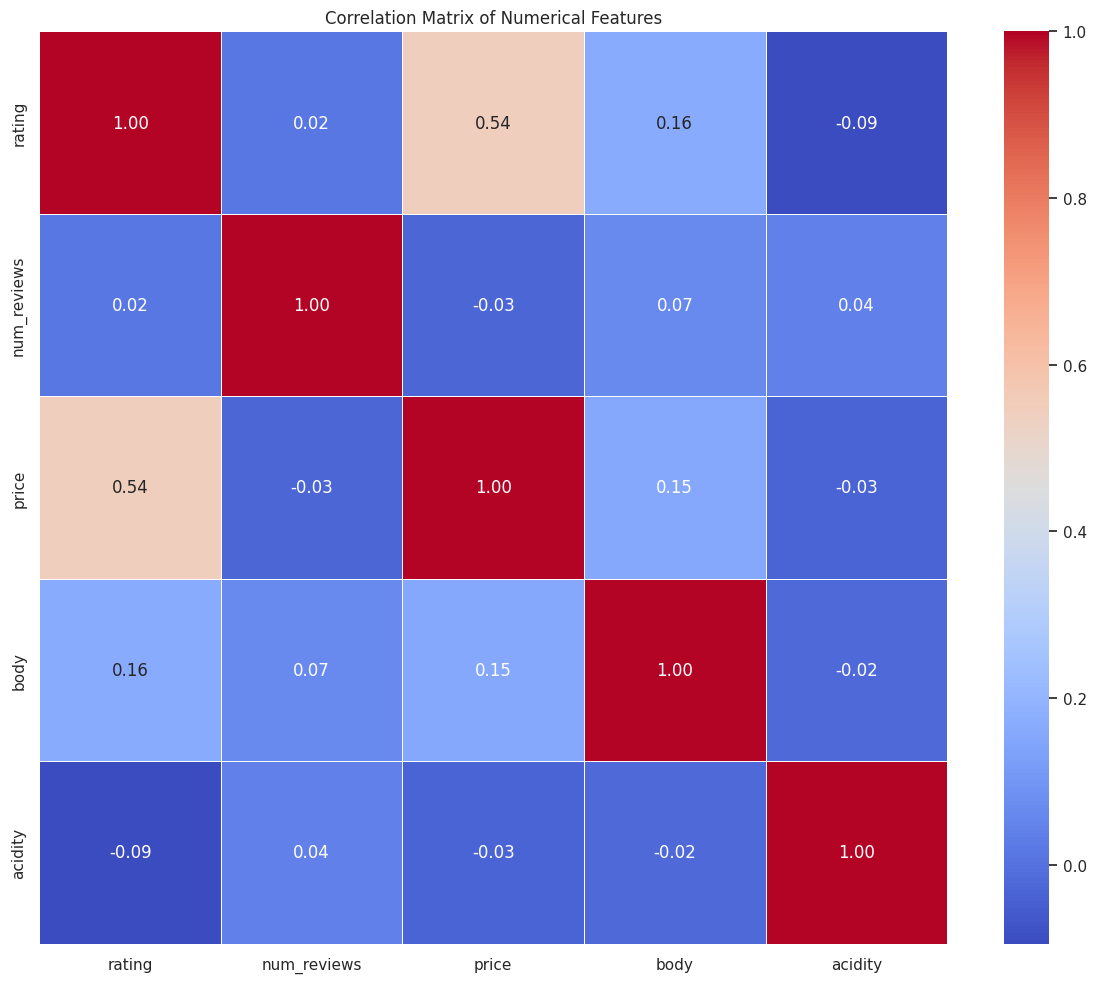

In [90]:
corr_matrix = wine_data.select_dtypes(include=['int64', 'float64']).corr()

# Visualize correlation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## 1.5 Analyze the relationship between wine type and price

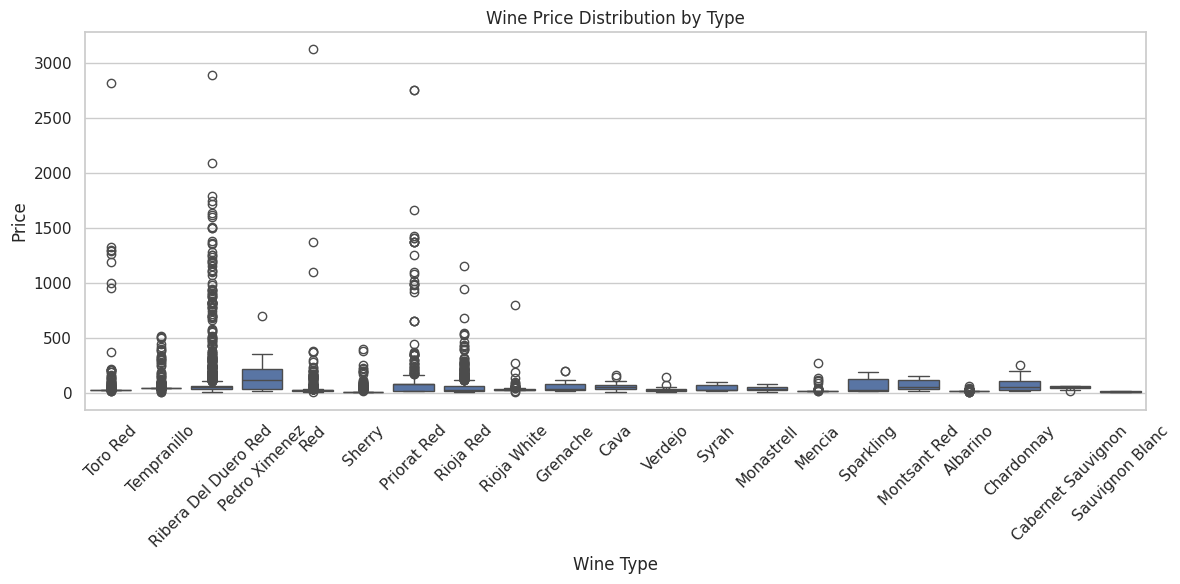

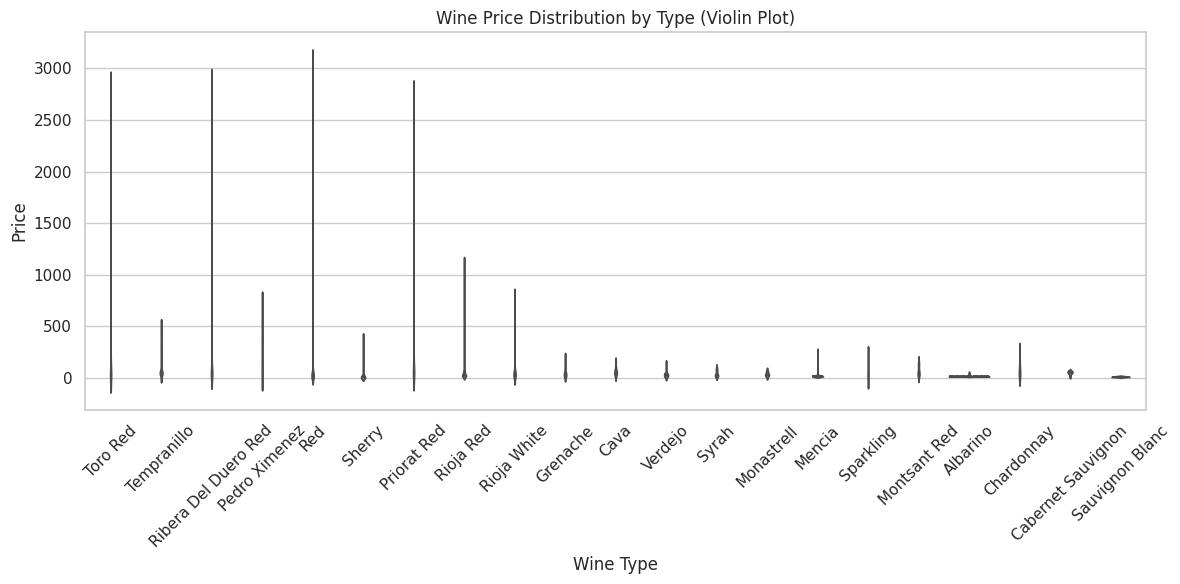

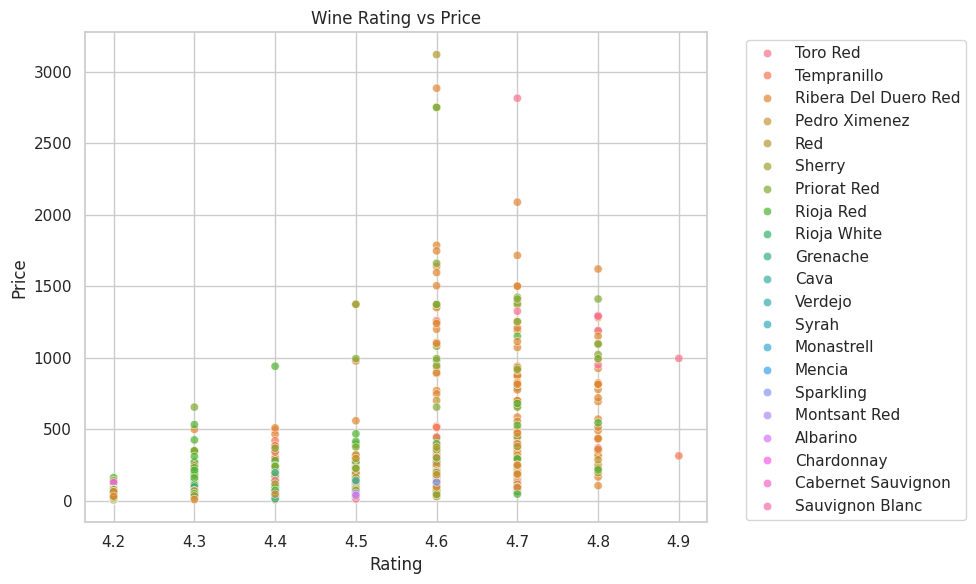

In [91]:
# Box plot to compare wine prices across different types
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='price', data=wine_data)
plt.title('Wine Price Distribution by Type')
plt.xlabel('Wine Type')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

# Violin plot for more detailed distribution view
plt.figure(figsize=(12, 6))
sns.violinplot(x='type', y='price', data=wine_data, inner='quartile')
plt.title('Wine Price Distribution by Type (Violin Plot)')
plt.xlabel('Wine Type')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

# Relationship between rating and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating', y='price', data=wine_data, hue='type', alpha=0.7)
plt.title('Wine Rating vs Price')
plt.xlabel('Rating')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 1.6 Identify missing values

In [92]:
print("\nMissing values in each column:")
missing_values = wine_data.isnull().sum()
missing_percentage = (missing_values / len(wine_data)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_info[missing_info['Missing Values'] > 0])


Missing values in each column:
         Missing Values  Percentage
year                  2    0.026667
type                545    7.266667
body               1169   15.586667
acidity            1169   15.586667


# 2. Preprocessing the Data

## 2.1 Handle missing values

In [93]:
# Identify numerical and categorical columns
numerical_cols = wine_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = wine_data.select_dtypes(include=['object', 'category']).columns.tolist()

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## 2.2 Prepare features (X) and target (y)

In [94]:
X = wine_data.drop(['price'], axis=1)  # Features
y = wine_data['price']  # Target

In [95]:
# Print the shape of X and y
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Display a sample of X to verify features
print("\nFeatures sample:")
X.head()

Features (X) shape: (7500, 10)
Target (y) shape: (7500,)

Features sample:


,winery,wine,year,rating,num_reviews,country,region,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,Ribera Del Duero Red,5.0,3.0


In [ ]:
# Print categorical columns and their unique values
cat_cols = X.select_dtypes(include=['object']).columns
print("\nCategorical columns and their unique values:")
for col in cat_cols:
    print(f"{col}: {X[col].unique()[:5]}{'...' if X[col].nunique() > 5 else ''}")

# Convert categorical columns to numeric using one-hot encoding
print("\nEncoding categorical variables with one-hot encoding")
X_encoded = pd.get_dummies(X, drop_first=False)
print(f"Features before encoding: {X.shape[1]} columns")
print(f"Features after encoding: {X_encoded.shape[1]} columns")

In [ ]:
# Handle any remaining non-numeric columns (should be none after one-hot encoding)
non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"Warning: Found non-numeric columns after encoding: {list(non_numeric)}")
    print("Converting these to numeric without dropping...")
    for col in non_numeric:
        X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce')

In [98]:
# Handle NaN values
nan_count = X_encoded.isna().sum().sum()
if nan_count > 0:
    print(f"Filling {nan_count} NaN values with column means")
    X_encoded = X_encoded.fillna(X_encoded.mean())

# Set X to the encoded version
X = X_encoded

Filling 2338 NaN values with column means


In [99]:
# Final verification
print(f"\nFinal features shape: {X.shape}")
print("First few encoded columns:", list(X.columns[:5]), "...")
print("All columns are numeric:", all(np.issubdtype(dtype, np.number) for dtype in X.dtypes))


Final features shape: (7500, 1500)
First few encoded columns: ['rating', 'num_reviews', 'body', 'acidity', 'winery_A Coroa'] ...
All columns are numeric: False


# 3. Model Selection and Training

## 3.1 Split data into training and testing sets

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set shape: X_test {X_test.shape}, y_test {y_test.shape}")

Training set shape: X_train (6000, 1500), y_train (6000,)
Test set shape: X_test (1500, 1500), y_test (1500,)


## 3.2 Create model pipelines

In [101]:
# Linear Regression
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")

# Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")

# SVR with try-except to handle potential issues
print("\nTraining SVR...")
svr_model = SVR()
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR - RMSE: {rmse_svr:.4f}, MAE: {mae_svr:.4f}, R2: {r2_svr:.4f}")

# Store results
results = {
    'Linear Regression': {'RMSE': rmse_lr, 'MAE': mae_lr, 'R2': r2_lr},
    'Random Forest': {'RMSE': rmse_rf, 'MAE': mae_rf, 'R2': r2_rf},
    'SVR': {'RMSE': rmse_svr, 'MAE': mae_svr, 'R2': r2_svr}
}

# Compare model performance
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Find the best model based on RMSE
best_model = results_df['RMSE'].idxmin()
print(f"\nBest model based on RMSE: {best_model}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])


Training Linear Regression...
Linear Regression - RMSE: 93.9745, MAE: 22.8420, R2: 0.6881

Training Random Forest...
Random Forest - RMSE: 84.5852, MAE: 16.7604, R2: 0.7473

Training SVR...
SVR - RMSE: 169.0512, MAE: 43.5592, R2: -0.0094

Model Comparison:
                         RMSE        MAE        R2
Linear Regression   93.974539  22.841991  0.688073
Random Forest       84.585189  16.760423  0.747291
SVR                169.051169  43.559250 -0.009413

Best model based on RMSE: Random Forest


# 4. Hyperparameter Tuning

In [102]:
param_grid = {
    'regressor__fit_intercept': [True, False]

}